<a href="https://colab.research.google.com/github/ndorazio137/jlabAirplanesHitBirds/blob/main/AirplanesThatHitBirds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read the Kaggle CSV file. Please upload your Kaggle API key json file when prompted. You can obtain one with a Kaggle account and "Creating an API Key" under the "My Account" Settings.

CST 383 Project
Machine Learning Strikes
BY Christal O’Connell, Brian James, Kyle Oakes, and Nick D’Orazio

In [ ]:
#1
!pip install kaggle
 
from google.colab import files
 
uploaded = files.upload()
 
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
 
!kaggle datasets download -d faa/wildlife-strikes
 
!unzip /content/wildlife-strikes.zip
 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
 
basepath = "/content/"
df = pd.read_csv(basepath + "database.csv")

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes
wildlife-strikes.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/wildlife-strikes.zip
replace database.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,12,15,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Checking for NaN values

In [ ]:
#2
df.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174104 entries, 0 to 174103
Data columns (total 66 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Record ID             174104 non-null  int64  
 1   Incident Year         174104 non-null  int64  
 2   Incident Month        174104 non-null  int64  
 3   Incident Day          174104 non-null  int64  
 4   Operator ID           174104 non-null  object 
 5   Operator              174104 non-null  object 
 6   Aircraft              174104 non-null  object 
 7   Aircraft Type         133074 non-null  object 
 8   Aircraft Make         131051 non-null  object 
 9   Aircraft Model        122439 non-null  object 
 10  Aircraft Mass         127320 non-null  float64
 11  Engine Make           123434 non-null  float64
 12  Engine Model          121988 non-null  object 
 13  Engines               127342 non-null  float64
 14  Engine Type           127282 non-null  object 
 15  

The sum of all NaN values in the DataFrame

In [ ]:
#3
df.isna().sum().sum()

1834042

In [ ]:
#4
df.describe()

,Record ID,Incident Year,Incident Month,Incident Day,Aircraft Mass,Engine Make,Engines,Engine2 Position,Engine4 Position,Height,Speed,Distance,Fatalities,Injuries,Aircraft Damage,Radome Strike,Radome Damage,Windshield Strike,Windshield Damage,Nose Strike,Nose Damage,Engine1 Strike,Engine1 Damage,Engine2 Strike,Engine2 Damage,Engine3 Strike,Engine3 Damage,Engine4 Strike,Engine4 Damage,Engine Ingested,Propeller Strike,Propeller Damage,Wing or Rotor Strike,Wing or Rotor Damage,Fuselage Strike,Fuselage Damage,Landing Gear Strike,Landing Gear Damage,Tail Strike,Tail Damage,Lights Strike,Lights Damage,Other Strike,Other Damage
count,174104.000000,174104.000000,174104.000000,174104.000000,127320.000000,123434.000000,127342.000000,118715.000000,3092.000000,103677.000000,71258.000000,99713.000000,565.000000,229.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000,174104.000000
mean,241204.036915,2006.036392,7.171840,15.712264,3.510611,21.306958,2.057656,2.918570,2.058538,831.032283,141.925622,0.703738,0.046018,1.746725,0.085977,0.107757,0.009150,0.138934,0.005956,0.122369,0.006577,0.055605,0.014445,0.045168,0.011619,0.003182,0.000971,0.001918,0.000425,0.055180,0.020086,0.003326,0.119159,0.024009,0.102703,0.004733,0.046242,0.005813,0.011235,0.004176,0.005962,0.004216,0.090727,0.008989
std,94013.682213,6.747708,2.790152,8.799405,0.873783,11.023161,0.469374,2.008204,1.441000,1803.650833,46.905651,3.464467,0.435164,6.571239,0.280331,0.310075,0.095216,0.345879,0.076947,0.327713,0.080829,0.229157,0.119318,0.207674,0.107166,0.056320,0.031141,0.043758,0.020612,0.228331,0.140294,0.057572,0.323976,0.153076,0.303571,0.068633,0.210010,0.076019,0.105397,0.064485,0.076983,0.064793,0.287222,0.094383
min,1000.000000,1990.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,205411.750000,2001.000000,5.000000,8.000000,3.000000,10.000000,2.000000,1.000000,1.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,249102.500000,2007.000000,8.000000,16.000000,4.000000,22.000000,2.000000,1.000000,1.000000,50.000000,138.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,322592.250000,2012.000000,9.000000,23.000000,4.000000,34.000000,2.000000,5.000000,4.000000,800.000000,160.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,367445.000000,2015.000000,12.000000,31.000000,5.000000,92.000000,4.000000,7.000000,5.000000,31300.000000,2500.000000,150.000000,8.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00

The data took to long to run so we cut it down to only the years after 2014. Historic data older than 2014 will not be used.

In [ ]:
#5
df2 =  df[(df['Incident Year'] > 2000) & (df['Incident Year'] < 2015)].copy()
df2

,Record ID,Incident Year,Incident Month,Incident Day,Operator ID,Operator,Aircraft,Aircraft Type,Aircraft Make,Aircraft Model,Aircraft Mass,Engine Make,Engine Model,Engines,Engine Type,Engine1 Position,Engine2 Position,Engine3 Position,Engine4 Position,Airport ID,Airport,State,FAA Region,Warning Issued,Flight Phase,Visibility,Precipitation,Height,Speed,Distance,Species ID,Species Name,Species Quantity,Flight Impact,Fatalities,Injuries,Aircraft Damage,Radome Strike,Radome Damage,Windshield Strike,Windshield Damage,Nose Strike,Nose Damage,Engine1 Strike,Engine1 Damage,Engine2 Strike,Engine2 Damage,Engine3 Strike,Engine3 Damage,Engine4 Strike,Engine4 Damage,Engine Ingested,Propeller Strike,Propeller Damage,Wing or Rotor Strike,Wing or Rotor Damage,Fuselage Strike,Fuselage Damage,Landing Gear Strike,Landing Gear Damage,Tail Strike,Tail Damage,Lights Strike,Lights Damage,Other Strike,Other Damage
39096,203146,2001,1,1,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KPHX,PHOENIX SKY HARBOR INTL ARPT,AZ,AWP,NaN,NaN,NaN,NaN,NaN,NaN,0.0,O2205,MOURNING DOVE,1,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39097,203841,2001,1,1,DAL,DELTA AIR LINES,MD-88,A,583,37,4.0,34.0,10,2.0,D,5,5.0,NaN,NaN,KLGA,LA GUARDIA ARPT,NY,AEA,N,TAKEOFF RUN,DAY,NONE,0.0,130.0,0.0,UNKBL,UNKNOWN LARGE BIRD,1,NONE,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39098,213591,2001,1,1,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHNL,HONOLULU INTL ARPT,HI,AWP,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N5122,PACIFIC GOLDEN-PLOVER,1,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39099,211928,2001,1,1,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHNL,HONOLULU INTL ARPT,HI,AWP,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N5122,PACIFIC GOLDEN-PLOVER,1,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39100,205787,2001,1,1,UAL,UNITED AIRLINES,A-320,A,04A,3,4.0,23.0,1,2.0,D,1,1.0,NaN,NaN,KSMF,SACRAMENTO INTL,CA,AWP,NaN,APPROACH,NIGHT,NONE,NaN,NaN,NaN,J2104,NORTHERN PINTAIL,2-10,NONE,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163951,356969,2014,12,31,FDX,FEDEX EXPRESS,DC-10-10,A,583,24,4.0,22.0,7,3.0,D,1,6.0,1,NaN,KMEM,MEMPHIS INTL,TN,ASO,NaN,TAKEOFF RUN,DAY,NONE,0.0,144.0,0.0,UNKBS,UNKNOWN SMALL BIRD,1,NONE,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
163952,356973,2014,12,31,UAL,UNITED AIRLINES,B-737-800,A,148,43,4.0,10.0,1,2.0,D,1,1.0,NaN,NaN,KEWR,NEWARK LIBERTY INTL ARPT,NJ,AEA,Y,LANDING ROLL,DAY,NONE,0.0,NaN,0.0,K3302,RED-TAILED HAWK,1,NONE,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
163953,356972,2014,12,31,SWA,SOUTHWEST AIRLINES,B-737-700,A,148,42,4.0,10.0,1,2.0,D,1,1.0,NaN,NaN,KONT,ONTARIO INTL ARPT,CA,AWP,Y,APPROACH,DAY,NONE,500.0,140.0,3.0,UNKBS,UNKNOWN SMALL BIRD,1,NONE,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
163954,356967,2014,12,31,DAL,DELTA AIR LINES,B-737-800,A,148,43,4.0,10.0,1,2.0,D,1,1.0,NaN,NaN,KSLC,SALT LAKE CITY INTL,UT,ANM,Y,APPROACH,DAY,NONE,NaN,NaN,NaN,NE104,RING-BILLED GULL,1,NONE,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0


Checked new row count and NaN values by column

In [ ]:
#6
df2.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124860 entries, 39096 to 163955
Data columns (total 66 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Record ID             124860 non-null  int64  
 1   Incident Year         124860 non-null  int64  
 2   Incident Month        124860 non-null  int64  
 3   Incident Day          124860 non-null  int64  
 4   Operator ID           124860 non-null  object 
 5   Operator              124860 non-null  object 
 6   Aircraft              124860 non-null  object 
 7   Aircraft Type         91705 non-null   object 
 8   Aircraft Make         90450 non-null   object 
 9   Aircraft Model        84616 non-null   object 
 10  Aircraft Mass         88378 non-null   float64
 11  Engine Make           86509 non-null   float64
 12  Engine Model          85608 non-null   object 
 13  Engines               88414 non-null   float64
 14  Engine Type           88373 non-null   object 
 

Checked reduced number of NaN values in the DataFrame

In [ ]:
#7
df2.isna().sum().sum()

1364112

In [ ]:
#8
df2.describe()

,Record ID,Incident Year,Incident Month,Incident Day,Aircraft Mass,Engine Make,Engines,Engine2 Position,Engine4 Position,Height,Speed,Distance,Fatalities,Injuries,Aircraft Damage,Radome Strike,Radome Damage,Windshield Strike,Windshield Damage,Nose Strike,Nose Damage,Engine1 Strike,Engine1 Damage,Engine2 Strike,Engine2 Damage,Engine3 Strike,Engine3 Damage,Engine4 Strike,Engine4 Damage,Engine Ingested,Propeller Strike,Propeller Damage,Wing or Rotor Strike,Wing or Rotor Damage,Fuselage Strike,Fuselage Damage,Landing Gear Strike,Landing Gear Damage,Tail Strike,Tail Damage,Lights Strike,Lights Damage,Other Strike,Other Damage
count,124860.000000,124860.000000,124860.000000,124860.000000,88378.000000,86509.000000,88414.000000,82830.000000,1769.000000,70335.000000,47315.000000,75661.000000,559.000000,121.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000,124860.000000
mean,269671.132284,2008.459731,7.219029,15.730242,3.533244,20.151372,2.038829,2.782977,2.285472,863.645056,143.406932,0.741161,0.033989,2.157025,0.069526,0.110091,0.007833,0.136329,0.004797,0.125284,0.006015,0.050280,0.010652,0.042391,0.008746,0.002419,0.000505,0.001378,0.000248,0.046997,0.017259,0.002459,0.119294,0.020719,0.104437,0.004333,0.044954,0.004525,0.010908,0.003644,0.005550,0.003724,0.102515,0.006784
std,70645.984391,4.021392,2.759684,8.794092,0.839259,10.853510,0.430054,1.997997,1.485761,1821.593181,47.276567,3.461273,0.419836,8.994450,0.254347,0.313005,0.088156,0.343139,0.069097,0.331042,0.077321,0.218524,0.102657,0.201481,0.093109,0.049121,0.022457,0.037090,0.015755,0.211632,0.130237,0.049525,0.324135,0.142443,0.305828,0.065682,0.207205,0.067117,0.103872,0.060256,0.074293,0.060912,0.303325,0.082083
min,1162.000000,2001.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,232410.750000,2005.000000,5.000000,8.000000,3.000000,10.000000,2.000000,1.000000,1.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,263754.500000,2009.000000,8.000000,16.000000,4.000000,22.000000,2.000000,1.000000,1.000000,50.000000,140.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,324910.250000,2012.000000,9.000000,23.000000,4.000000,31.000000,2.000000,5.000000,4.000000,900.000000,160.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,365935.000000,2014.000000,12.000000,31.000000,5.000000,92.000000,4.000000,7.000000,5.000000,31300.000000,2500.000000,150.000000,8.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,

In [ ]:
#9
#Nick
unique_operators = df2['Operator'].unique()
df_unique_operators = pd.DataFrame(data=unique_operators, columns=['Operator'])
df_unique_operators

,Operator
0,UNKNOWN
1,DELTA AIR LINES
2,UNITED AIRLINES
3,AIR NEW ZEALAND
4,AMERICAN AIRLINES
...,...
398,SEABORNE AIRLINES
399,JETAIRFLY
400,NORWEGIAN
401,JEJU AIR


In [ ]:
#10
unique_aircraft = df2['Aircraft'].unique()
df_unique_aircraft = pd.DataFrame(data=unique_aircraft, columns=['Aircraft'])
df_unique_aircraft

,Aircraft
0,UNKNOWN
1,MD-88
2,A-320
3,B-767
4,MD-80
...,...
547,BE-T34A
548,FORD TRIMOTOR
549,B-787-9
550,ROBINSON R66


In [ ]:
#11
unique_airport = df2['Airport'].unique()
df_unique_airport = pd.DataFrame(data=unique_airport, columns=['Airport'])
df_unique_airport

,Airport
0,PHOENIX SKY HARBOR INTL ARPT
1,LA GUARDIA ARPT
2,HONOLULU INTL ARPT
3,SACRAMENTO INTL
4,DALLAS/FORT WORTH INTL ARPT
...,...
1892,DUKE UNIV NORTH HELIPORT
1893,MARSHALL MEMORIAL MUNICIPAL ARPT
1894,QUAHADI RANCH ARPT
1895,SOUTH BIMINI ARPT


In [ ]:
operator_type = df2['Operator'].mask(df2['Operator'] != 'MILITARY', 'COMMERCIAL', inplace=False)
unique_operator_type = operator_type.unique()
df_unique_operator_type = pd.DataFrame(data=unique_operator_type, columns=['Operator Type'])
dict = pd.Series(df_unique_operator_type.index,index=df_unique_operator_type['Operator Type'].values).to_dict()
df2['Unique Operator Type Value'] = operator_type.map(dict)
df2

,Record ID,Incident Year,Incident Month,Incident Day,Operator ID,Operator,Aircraft,Aircraft Type,Aircraft Make,Aircraft Model,Aircraft Mass,Engine Make,Engine Model,Engines,Engine Type,Engine1 Position,Engine2 Position,Engine3 Position,Engine4 Position,Airport ID,Airport,State,FAA Region,Warning Issued,Flight Phase,Visibility,Precipitation,Height,Speed,Distance,Species ID,Species Name,Species Quantity,Flight Impact,Fatalities,Injuries,Aircraft Damage,Radome Strike,Radome Damage,Windshield Strike,Windshield Damage,Nose Strike,Nose Damage,Engine1 Strike,Engine1 Damage,Engine2 Strike,Engine2 Damage,Engine3 Strike,Engine3 Damage,Engine4 Strike,Engine4 Damage,Engine Ingested,Propeller Strike,Propeller Damage,Wing or Rotor Strike,Wing or Rotor Damage,Fuselage Strike,Fuselage Damage,Landing Gear Strike,Landing Gear Damage,Tail Strike,Tail Damage,Lights Strike,Lights Damage,Other Strike,Other Damage,Unique Operator Type Value
39096,203146,2001,1,1,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KPHX,PHOENIX SKY HARBOR INTL ARPT,AZ,AWP,NaN,NaN,NaN,NaN,NaN,NaN,0.0,O2205,MOURNING DOVE,1,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39097,203841,2001,1,1,DAL,DELTA AIR LINES,MD-88,A,583,37,4.0,34.0,10,2.0,D,5,5.0,NaN,NaN,KLGA,LA GUARDIA ARPT,NY,AEA,N,TAKEOFF RUN,DAY,NONE,0.0,130.0,0.0,UNKBL,UNKNOWN LARGE BIRD,1,NONE,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39098,213591,2001,1,1,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHNL,HONOLULU INTL ARPT,HI,AWP,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N5122,PACIFIC GOLDEN-PLOVER,1,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39099,211928,2001,1,1,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHNL,HONOLULU INTL ARPT,HI,AWP,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N5122,PACIFIC GOLDEN-PLOVER,1,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39100,205787,2001,1,1,UAL,UNITED AIRLINES,A-320,A,04A,3,4.0,23.0,1,2.0,D,1,1.0,NaN,NaN,KSMF,SACRAMENTO INTL,CA,AWP,NaN,APPROACH,NIGHT,NONE,NaN,NaN,NaN,J2104,NORTHERN PINTAIL,2-10,NONE,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163951,356969,2014,12,31,FDX,FEDEX EXPRESS,DC-10-10,A,583,24,4.0,22.0,7,3.0,D,1,6.0,1,NaN,KMEM,MEMPHIS INTL,TN,ASO,NaN,TAKEOFF RUN,DAY,NONE,0.0,144.0,0.0,UNKBS,UNKNOWN SMALL BIRD,1,NONE,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
163952,356973,2014,12,31,UAL,UNITED AIRLINES,B-737-800,A,148,43,4.0,10.0,1,2.0,D,1,1.0,NaN,NaN,KEWR,NEWARK LIBERTY INTL ARPT,NJ,AEA,Y,LANDING ROLL,DAY,NONE,0.0,NaN,0.0,K3302,RED-TAILED HAWK,1,NONE,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
163953,356972,2014,12,31,SWA,SOUTHWEST AIRLINES,B-737-700,A,148,42,4.0,10.0,1,2.0,D,1,1.0,NaN,NaN,KONT,ONTARIO INTL ARPT,CA,AWP,Y,APPROACH,DAY,NONE,500.0,140.0,3.0,UNKBS,UNKNOWN SMALL BIRD,1,NONE,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
163954,356967,2014,12,31,DAL,DELTA AIR LINES,B-737-800,A,148,43,4.0,10.0,1,2.0,D,1,1.0,NaN,NaN,KSLC,SALT LAKE CITY INTL,UT,ANM,Y,APPROACH,DAY,NONE,NaN,NaN,NaN,NE104,RING-BILLED GULL,1,NONE,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
#12
dict = pd.Series(df_unique_operators.index,index=df_unique_operators.Operator.values).to_dict()
df2['Unique Operator Value'] = df2['Operator'].map(dict)

In [ ]:
#13
dict = pd.Series(df_unique_aircraft.index,index=df_unique_aircraft.Aircraft.values).to_dict()
df2['Unique Aircraft Value'] = df2['Aircraft'].map(dict)

In [ ]:
#14
dict = pd.Series(df_unique_airport.index,index=df_unique_airport.Airport.values).to_dict()
df2['Unique Airport Value'] = df2['Airport'].map(dict)

In [ ]:
unique_aircraft_type = df2['Aircraft Type'].unique()
df_unique_aircraft_type = pd.DataFrame(data=unique_aircraft_type, columns=['Aircraft Type'])


In [ ]:
dict = pd.Series(df_unique_aircraft_type.index,index=df_unique_aircraft_type['Aircraft Type'].values).to_dict()
df2['Unique Aircraft Type Value'] = df2['Aircraft Type'].map(dict)

In [ ]:
unique_aircraft_make = df2['Aircraft Make'].unique()
df_unique_aircraft_make = pd.DataFrame(data=unique_aircraft_make, columns=['Aircraft Make'])

In [ ]:
dict = pd.Series(df_unique_aircraft_make.index,index=df_unique_aircraft_make['Aircraft Make'].values).to_dict()
df2['Unique Aircraft Make Value'] = df2['Aircraft Make'].map(dict)

In [ ]:
unique_engine_type = df2['Engine Type'].unique()
df_unique_engine_type = pd.DataFrame(data=unique_engine_type, columns=['Engine Type'])

In [ ]:
dict = pd.Series(df_unique_engine_type.index,index=df_unique_engine_type['Engine Type'].values).to_dict()
df2['Unique Engine Type Value'] = df2['Engine Type'].map(dict)

In [ ]:
unique_state = df2['State'].unique()
df_unique_state = pd.DataFrame(data=unique_state, columns=['State'])

In [ ]:
dict = pd.Series(df_unique_state.index,index=df_unique_state['State'].values).to_dict()
df2['Unique State Value'] = df2['State'].map(dict)

In [ ]:
unique_faa = df2['FAA Region'].unique()
df_faa = pd.DataFrame(data=unique_faa, columns=['FAA Region'])

In [ ]:
dict = pd.Series(df_faa.index,index=df_faa['FAA Region'].values).to_dict()
df2['Unique FAA Region Value'] = df2['FAA Region'].map(dict)

In [ ]:
unique_warning = df2['Warning Issued'].unique()
unique_warning = pd.DataFrame(data=unique_warning, columns=['Warning Issued'])

In [ ]:
dict = pd.Series(unique_warning.index,index=unique_warning['Warning Issued'].values).to_dict()
df2['Unique Warning Issued Value'] = df2['Warning Issued'].map(dict)

In [ ]:
unique_flight_phase = df2['Flight Phase'].unique()
unique_flight_phase = pd.DataFrame(data=unique_flight_phase, columns=['Flight Phase'])

In [ ]:
dict = pd.Series(unique_flight_phase.index,index=unique_flight_phase['Flight Phase'].values).to_dict()
df2['Unique Flight Phase Value'] = df2['Flight Phase'].map(dict)

In [ ]:
unique_visibility = df2['Visibility'].unique()
unique_visibility = pd.DataFrame(data=unique_visibility, columns=['Visibility'])

In [ ]:
dict = pd.Series(unique_visibility.index,index=unique_visibility['Visibility'].values).to_dict()
df2['Unique Visibility Value'] = df2['Visibility'].map(dict)

In [ ]:
unique_precipitation = df2['Precipitation'].unique()
unique_precipitation = pd.DataFrame(data=unique_precipitation, columns=['Precipitation'])

In [ ]:
dict = pd.Series(unique_precipitation.index,index=unique_precipitation['Precipitation'].values).to_dict()
df2['Unique Precipitation Value'] = df2['Precipitation'].map(dict)

In [ ]:
unique_species_name = df2['Species Name'].unique()
unique_species_name = pd.DataFrame(data=unique_species_name, columns=['Species Name'])

In [ ]:
dict = pd.Series(unique_species_name.index,index=unique_species_name['Species Name'].values).to_dict()
df2['Unique Species Name Value'] = df2['Species Name'].map(dict)

In [ ]:
unique_flight_impact = df2['Flight Impact'].unique()
unique_flight_impact = pd.DataFrame(data=unique_flight_impact, columns=['Flight Impact'])

In [ ]:
dict = pd.Series(unique_flight_impact.index,index=unique_flight_impact['Flight Impact'].values).to_dict()
df2['Unique Flight Impact Value'] = df2['Flight Impact'].map(dict)

In [ ]:
unique_flight_impact = df2['Flight Impact'].unique()
unique_flight_impact = pd.DataFrame(data=unique_flight_impact, columns=['Flight Impact'])

In [ ]:
#15
df2 = df2.drop(['Fatalities',	'Injuries'], axis=1)
df2.head(50)

,Record ID,Incident Year,Incident Month,Incident Day,Operator ID,Operator,Aircraft,Aircraft Type,Aircraft Make,Aircraft Model,Aircraft Mass,Engine Make,Engine Model,Engines,Engine Type,Engine1 Position,Engine2 Position,Engine3 Position,Engine4 Position,Airport ID,Airport,State,FAA Region,Warning Issued,Flight Phase,Visibility,Precipitation,Height,Speed,Distance,Species ID,Species Name,Species Quantity,Flight Impact,Aircraft Damage,Radome Strike,Radome Damage,Windshield Strike,Windshield Damage,Nose Strike,Nose Damage,Engine1 Strike,Engine1 Damage,Engine2 Strike,Engine2 Damage,Engine3 Strike,Engine3 Damage,Engine4 Strike,Engine4 Damage,Engine Ingested,Propeller Strike,Propeller Damage,Wing or Rotor Strike,Wing or Rotor Damage,Fuselage Strike,Fuselage Damage,Landing Gear Strike,Landing Gear Damage,Tail Strike,Tail Damage,Lights Strike,Lights Damage,Other Strike,Other Damage,Unique Operator Type Value,Unique Operator Value,Unique Aircraft Value,Unique Airport Value,Unique Aircraft Type Value,Unique Aircraft Make Value,Unique Engine Type Value,Unique State Value,Unique FAA Region Value,Unique Warning Issued Value,Unique Flight Phase Value,Unique Visibility Value,Unique Precipitation Value,Unique Species Name Value,Unique Flight Impact Value
39096,203146,2001,1,1,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KPHX,PHOENIX SKY HARBOR INTL ARPT,AZ,AWP,NaN,NaN,NaN,NaN,NaN,NaN,0.0,O2205,MOURNING DOVE,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39097,203841,2001,1,1,DAL,DELTA AIR LINES,MD-88,A,583,37,4.0,34.0,10,2.0,D,5,5.0,NaN,NaN,KLGA,LA GUARDIA ARPT,NY,AEA,N,TAKEOFF RUN,DAY,NONE,0.0,130.0,0.0,UNKBL,UNKNOWN LARGE BIRD,1,NONE,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
39098,213591,2001,1,1,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHNL,HONOLULU INTL ARPT,HI,AWP,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N5122,PACIFIC GOLDEN-PLOVER,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,2,0
39099,211928,2001,1,1,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHNL,HONOLULU INTL ARPT,HI,AWP,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N5122,PACIFIC GOLDEN-PLOVER,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,2,0
39100,205787,2001,1,1,UAL,UNITED AIRLINES,A-320,A,04A,3,4.0,23.0,1,2.0,D,1,1.0,NaN,NaN,KSMF,SACRAMENTO INTL,CA,AWP,NaN,APPROACH,NIGHT,NONE,NaN,NaN,NaN,J2104,NORTHERN PINTAIL,2-10,NONE,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,2,2,3,1,2,1,3,0,0,2,2,1,3,1
39101,212956,2001,1,1,ANZ,AIR NEW ZEALAND,B-767,A,148,98,4.0,NaN,NaN,2.0,D,1,1.0,NaN,NaN,PHNL,HONOLULU INTL ARPT,HI,AWP,N,TAXI,NIGHT,NaN,0.0,NaN,0.0,N5122,PACIFIC GOLDEN-PLOVER,1,NONE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,2,1,3,1,2,0,1,3,2,0,2,1
39102,206058,2001,1,2,AAL,AMERICAN AIRLINES,MD-80,A,583,37,4.0,34.0,10,2.0,D,5,5.0,NaN,NaN,KDFW,DALLAS/FORT WORTH INTL ARPT,TX,ASW,N,DESCENT,NIGHT,NONE,3500.0,210.0,NaN,UNKBM,UNKNOWN MEDIUM BIRD,1,NONE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,4,4,1,1,1,4,2,1,4,2,1,4,1
39103,214075,2001,1,2,DAL,DELTA AIR LINES,B-737-300,A,148,24,4.0,10.0,1,2.0,D,1,1.0,NaN,NaN,KSLC,SALT LAKE CITY INTL,UT,ANM,N,LANDING ROLL,DAY,FOG,0.0,NaN,0.0,UNKBS,UNKNOWN SMALL BIRD,1,NONE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,5,1,3,1,5,3,1,5,1,2,5,1
39104,205822,2001,1,2,USA,1US AIRWAYS,B-737-200,A,148,13,4.0,34.0,10,2.0,D,1,1.0,NaN,NaN,KMSY,LOUIE ARMSTRONG NEW ORLEANS INTL ARPT,LA,ASW,NaN,APPROACH,DAY,NONE,NaN,250.0,NaN,UNKBM,UNKNOWN MEDIUM BIRD,1,NONE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,6,6,1,3,1,6,2,0,2,1,1,4,1
39105,208473,2001,1,2,BUS,BUSINESS,DHC6,A,303,6,2.0,31.0,4,2.0,C,4,4.0,NaN,NaN,KVGT,NORTH LAS VEGAS,NV,AWP,NaN,APPROACH,NaN,NaN,NaN,NaN,0.0,1F11,COYOTE,NaN,OTHER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,7

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124860 entries, 39096 to 163955
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Record ID                    124860 non-null  int64  
 1   Incident Year                124860 non-null  int64  
 2   Incident Month               124860 non-null  int64  
 3   Incident Day                 124860 non-null  int64  
 4   Operator ID                  124860 non-null  object 
 5   Operator                     124860 non-null  object 
 6   Aircraft                     124860 non-null  object 
 7   Aircraft Type                91705 non-null   object 
 8   Aircraft Make                90450 non-null   object 
 9   Aircraft Model               84616 non-null   object 
 10  Aircraft Mass                88378 non-null   float64
 11  Engine Make                  86509 non-null   float64
 12  Engine Model                 85608 non-null   object 


In [ ]:
df_counts = df2
df_counts = df_counts.groupby('Incident Month').count()
df_counts

,Record ID,Incident Year,Incident Day,Operator ID,Operator,Aircraft,Aircraft Type,Aircraft Make,Aircraft Model,Aircraft Mass,Engine Make,Engine Model,Engines,Engine Type,Engine1 Position,Engine2 Position,Engine3 Position,Engine4 Position,Airport ID,Airport,State,FAA Region,Warning Issued,Flight Phase,Visibility,Precipitation,Height,Speed,Distance,Species ID,Species Name,Species Quantity,Flight Impact,Aircraft Damage,Radome Strike,Radome Damage,Windshield Strike,Windshield Damage,Nose Strike,Nose Damage,Engine1 Strike,Engine1 Damage,Engine2 Strike,Engine2 Damage,Engine3 Strike,Engine3 Damage,Engine4 Strike,Engine4 Damage,Engine Ingested,Propeller Strike,Propeller Damage,Wing or Rotor Strike,Wing or Rotor Damage,Fuselage Strike,Fuselage Damage,Landing Gear Strike,Landing Gear Damage,Tail Strike,Tail Damage,Lights Strike,Lights Damage,Other Strike,Other Damage,Unique Operator Type Value,Unique Operator Value,Unique Aircraft Value,Unique Airport Value,Unique Aircraft Type Value,Unique Aircraft Make Value,Unique Engine Type Value,Unique State Value,Unique FAA Region Value,Unique Warning Issued Value,Unique Flight Phase Value,Unique Visibility Value,Unique Precipitation Value,Unique Species Name Value,Unique Flight Impact Value
Incident Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4088,4088,4088,4088,4088,4088,3023,2985,2818,2929,2847,2815,2929,2923,2897,2701,200,71,4088,4088,3641,3742,1743,2784,2535,2069,2396,1611,2491,4088,4088,3966,2368,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088,4088
2,3690,3690,3690,3690,3690,3690,2675,2626,2487,2577,2518,2476,2573,2572,2534,2373,192,64,3690,3690,3224,3321,1515,2424,2217,1798,2078,1395,2234,3690,3690,3565,2088,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690
3,5929,5929,5929,5929,5929,5929,4450,4392,4164,4327,4226,4181,4322,4319,4270,3993,303,96,5929,5929,5050,5193,2470,3915,3621,3028,3370,2326,3258,5929,5927,5764,3540,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929
4,9005,9005,9005,9005,9005,9005,7006,6902,6495,6731,6611,6544,6734,6729,6668,6305,587,159,9005,9005,7559,7756,3746,6075,5639,4582,5220,3685,4721,9005,9005,8709,5507,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005,9005
5,12129,12129,12129,12129,12129,12129,9678,9551,9007,9321,9136,9063,9326,9320,9241,8824,887,215,12129,12129,10094,10321,4887,8212,7559,5991,6995,4925,6260,12129,12127,11765,7396,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129,12129
6,10680,10680,10680,10680,10680,10680,7188,7084,6633,6891,6734,6650,6897,6896,6829,6495,422,145,10680,10680,9549,9772,3976,6541,6030,4763,5730,3579,7488,10680,10679,10344,5483,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680,10680
7,16184,16184,16184,16184,16184,16184,10574,10404,9599,10057,9775,9678,10074,10072,9991,9417,591,186,16184,16184,14881,15120,6112,9841,9120,7461,8732,5397,12007,16184,16177,15631,8424,16184,16184,16184,16184,16184,

In [ ]:
df_mean = df2
df_mean = df_mean.groupby('Incident Month').mean()
df_mean

,Record ID,Incident Year,Incident Day,Aircraft Mass,Engine Make,Engines,Engine2 Position,Engine4 Position,Height,Speed,Distance,Aircraft Damage,Radome Strike,Radome Damage,Windshield Strike,Windshield Damage,Nose Strike,Nose Damage,Engine1 Strike,Engine1 Damage,Engine2 Strike,Engine2 Damage,Engine3 Strike,Engine3 Damage,Engine4 Strike,Engine4 Damage,Engine Ingested,Propeller Strike,Propeller Damage,Wing or Rotor Strike,Wing or Rotor Damage,Fuselage Strike,Fuselage Damage,Landing Gear Strike,Landing Gear Damage,Tail Strike,Tail Damage,Lights Strike,Lights Damage,Other Strike,Other Damage,Unique Operator Type Value,Unique Operator Value,Unique Aircraft Value,Unique Airport Value,Unique Aircraft Type Value,Unique Aircraft Make Value,Unique Engine Type Value,Unique State Value,Unique FAA Region Value,Unique Warning Issued Value,Unique Flight Phase Value,Unique Visibility Value,Unique Precipitation Value,Unique Species Name Value,Unique Flight Impact Value
Incident Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,261397.485323,2007.986546,15.611301,3.500854,20.199157,2.023899,2.724546,2.014085,470.927379,134.059590,0.425223,0.115215,0.097847,0.013209,0.111546,0.007583,0.107632,0.009540,0.066047,0.019569,0.062622,0.020303,0.005382,0.002202,0.001712,0.000489,0.072652,0.026174,0.004648,0.155088,0.034491,0.105431,0.006605,0.065068,0.008562,0.015411,0.006849,0.010274,0.008806,0.107877,0.011008,0.034247,26.258317,58.102984,147.411448,0.752691,4.419521,0.919031,12.971624,2.932975,0.646037,2.251223,0.954012,0.640166,36.160470,0.811888
2,262682.388076,2008.216802,14.949593,3.457897,20.354647,2.035367,2.841972,2.125000,512.357074,134.981362,0.382688,0.111382,0.102981,0.011382,0.102168,0.008672,0.107859,0.010840,0.057724,0.014905,0.052304,0.011924,0.002981,0.000271,0.001084,0.000813,0.063957,0.023035,0.004336,0.150136,0.032791,0.106775,0.007588,0.065312,0.007317,0.018157,0.007046,0.010027,0.007859,0.102710,0.010840,0.038482,28.239295,57.981030,155.203252,0.739566,4.546883,0.911382,13.519512,3.166938,0.603252,2.237669,0.919512,0.612466,38.546612,0.739024
3,263198.510879,2008.083825,16.747512,3.497573,20.465215,2.025914,2.698472,2.375000,1036.571810,147.496561,0.858157,0.133075,0.103221,0.014842,0.128015,0.011638,0.118570,0.011469,0.064598,0.017035,0.053297,0.017204,0.002361,0.000843,0.001349,0.000506,0.066116,0.020408,0.005229,0.141845,0.041828,0.110305,0.007758,0.053635,0.006409,0.016698,0.008264,0.006915,0.004554,0.093945,0.014168,0.032215,28.766740,59.021757,155.877214,0.768426,4.461461,0.945691,14.586440,3.343060,0.599595,2.193625,0.945522,0.622027,41.370552,0.815989
4,264442.551360,2008.317490,16.904275,3.581489,20.190138,2.056133,2.655511,2.283019,1286.461877,152.809769,1.298348,0.087396,0.117823,0.010883,0.148029,0.005886,0.131038,0.009106,0.051638,0.011993,0.043976,0.009550,0.003109,0.000333,0.001777,0.000444,0.049084,0.015103,0.002665,0.128928,0.025430,0.112049,0.005886,0.044753,0.004886,0.011882,0.003443,0.005775,0.003776,0.096169,0.008773,0.040866,29.552693,61.836868,147.158023,0.795891,4.480178,0.941033,15.080067,3.434314,0.575125,2.231982,0.964686,0.597002,43.970572,0.765242
5,266542.003133,2008.412318,15.059857,3.612702,20.681589,2.074416,2.655825,2.395349,1200.993853,151.564670,1.316593,0.057960,0.128205,0.007503,0.160772,0.003545,0.138511,0.004864,0.044934,0.008657,0.039327,0.007585,0.002309,0.000247,0.001319,0.000165,0.043862,0.013604,0.001731,0.109655,0.014840,0.119054,0.003215,0.036854,0.002968,0.008904,0.002803,0.003545,0.002473,0.093165,0.005854,0.038750,32.989282,63.149641,139.726523,0.815813,4.405227,0.939237,16.248743,3.734603,0.569709,2.207684,0.942287,0.579850,47.083354,0.738890
6,269521.342228,2008.575375,16.135393,3.545494,20.130829,2.033783,2.816012,1.979310,396.761955,132.916178,0.232356,0.051217,0.088858,0.003558,0.117978,0.003371,0.106180,0.003371,0.041667,0.009925,0.036891,0.005993,0.002996,0.001030,0.001217,0.000094,0.041573,0.014045,0.002060,0.094476,0.012828,0.087266,0.002622,0.044382,0.003933

In [ ]:
operator_value_counts = df2['Operator'].value_counts()
operator_value_counts

UNKNOWN               31841
SOUTHWEST AIRLINES    11184
BUSINESS               9534
UNITED AIRLINES        8273
FEDEX EXPRESS          5462
                      ...  
ROYAL JET                 1
AEROLOGIC                 1
INTERJET                  1
AIR 2000                  1
AIR 500                   1
Name: Operator, Length: 403, dtype: int64

In [ ]:
aircraft_value_counts = df2['Aircraft'].value_counts()
aircraft_value_counts

UNKNOWN       32913
B-737-700      6624
A-320          5985
B-737-300      5953
CRJ100/200     5638
              ...  
SOCATA TB9        1
H-60              1
ALON A2           1
UH-1H             1
B-787-9           1
Name: Aircraft, Length: 552, dtype: int64

In [ ]:
airport_value_counts = df2['Airport'].value_counts()
airport_value_counts

UNKNOWN                        14004
DENVER INTL AIRPORT             4605
DALLAS/FORT WORTH INTL ARPT     3505
CHICAGO O'HARE INTL ARPT        2523
MEMPHIS INTL                    2342
                               ...  
SEASIDE MUNICIPAL ARPT             1
CAPODICHINO (NAPLES)               1
MCMINN COUNTY ARPT                 1
NEW GARDEN                         1
SKY RANCH ARPT                     1
Name: Airport, Length: 1896, dtype: int64

In [ ]:
month_value_counts = df2['Incident Month'].value_counts()
month_value_counts

8     17518
9     16635
7     16184
10    15747
5     12129
6     10680
4      9005
11     8309
3      5929
12     4946
1      4088
2      3690
Name: Incident Month, dtype: int64

In [ ]:
pivot_aircraft_by_month = pd.pivot_table(data=df2,
                    index='Incident Month',
                    columns='Aircraft',
                    aggfunc='count')
pivot_aircraft_by_month

Aircraft Damage               ... Wing or Rotor Strike                     
Aircraft                  A-10 A-10A  A-300  ...              WC-135C WC-135W ZODIAC CH601
Incident Month                               ...                                          
1                          1.0   1.0   38.0  ...                  NaN     NaN          NaN
2                          NaN   2.0   36.0  ...                  NaN     NaN          NaN
3                          NaN   1.0  115.0  ...                  NaN     NaN          NaN
4                          NaN   NaN  224.0  ...                  NaN     1.0          NaN
5                          NaN   4.0  408.0  ...                  NaN     1.0          NaN
6                          1.0   5.0  146.0  ...                  NaN     NaN          1.0
7                          NaN   8.0  189.0  ...                  NaN     NaN          NaN
8                          1.0  16.0  298.0  ...                  NaN     NaN          NaN
9                          NaN   7.0  503.0  ...                  1.0     NaN          NaN
10                         3.0  10.0  419.0  ...                  NaN     NaN          NaN
11                         NaN   3.0  139.0  ...                  NaN     NaN          NaN
12                         NaN   NaN   57.0  ...                  NaN     NaN          NaN

[12 rows x 42504 columns]

In [ ]:
pivot_operator_by_month = pd.pivot_table(data=df2,
                    index='Incident Month',
                    columns='Operator',
                    aggfunc='count')
pivot_operator_by_month

Aircraft                  ... Wing or Rotor Strike             
Operator       1US AIRWAYS ABELAG AVIATION  ...                XOJET XTRA AIRWAYS
Incident Month                              ...                                  
1                     48.0             NaN  ...                  NaN          NaN
2                     40.0             NaN  ...                  1.0          NaN
3                     94.0             NaN  ...                  2.0          1.0
4                    100.0             NaN  ...                  3.0          4.0
5                    128.0             NaN  ...                  3.0          1.0
6                    116.0             NaN  ...                  NaN          NaN
7                    165.0             1.0  ...                  7.0          3.0
8                    185.0             NaN  ...                  6.0          1.0
9                    173.0             NaN  ...                  6.0          2.0
10                   179.0             NaN  ...                  3.0          2.0
11                   109.0             NaN  ...                  3.0          1.0
12                    49.0             NaN  ...                  1.0          3.0

[12 rows x 31031 columns]

In [ ]:
pivot_airport_by_month = pd.pivot_table(data=df2,
                    index='Incident Month',
                    columns='Airport',
                    aggfunc='count')
pivot_airport_by_month

Aircraft  ... Wing or Rotor Strike
Airport        ABERDEEN REGIONAL AR  ...               ZURICH
Incident Month                       ...                     
1                               1.0  ...                  NaN
2                               1.0  ...                  NaN
3                               NaN  ...                  NaN
4                               7.0  ...                  NaN
5                               9.0  ...                  NaN
6                              11.0  ...                  2.0
7                              24.0  ...                  3.0
8                              47.0  ...                  2.0
9                              12.0  ...                  NaN
10                             13.0  ...                  NaN
11                              2.0  ...                  1.0
12                              1.0  ...                  NaN

[12 rows x 145992 columns]

Below is a set of scatterplots we've used to check for correlations among the number of collisions and the columns 'Incident Month', 'Unique Operator Value', 'Unique Aircraft Value', and 'Unique Airport Value'.
Conclusions:
*   There seems to be a positive correlation between 'Incident Month' and each other column considered. This is likely due to an increase in the number of collisions reported.

In [ ]:
#sns.pairplot(df2, vars=['Record ID', 'Incident Month', 'Unique Operator Value', 'Unique Aircraft Value', 'Unique Airport Value'], kind="scatter");

In [ ]:
#sns.jointplot(data=df2, x="Incident Month", y="Unique Aircraft Value", kind="kde")

In [ ]:
# Kyle's preliminary plot
df3 = df[['Operator','Aircraft', 'Airport ID', 'Incident Month', 'Incident Year', 'Incident Day']].copy()
# The following few lines would only need to be present if we were predicting Aircraft or Airport ID.
#df3 = df3.loc[df['Aircraft'] != 'UNKNOWN']
#df3 = df3.loc[df['Airport ID'] != 'UNKN']
#df3 = df3.loc[df['Airport ID'] != 'ZZZZ']
df3.dropna(axis=0)
df3.info()
df3['Incident Month'].value_counts().sort_index()
df3.isna().sum().sum()
df3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174104 entries, 0 to 174103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Operator        174104 non-null  object
 1   Aircraft        174104 non-null  object
 2   Airport ID      174104 non-null  object
 3   Incident Month  174104 non-null  int64 
 4   Incident Year   174104 non-null  int64 
 5   Incident Day    174104 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 8.0+ MB


,Operator,Aircraft,Airport ID,Incident Month,Incident Year,Incident Day
0,DELTA AIR LINES,B-757-200,KCVG,1,1990,1
1,HAWAIIAN AIR,DC-9,PHLI,1,1990,1
2,UNKNOWN,UNKNOWN,PHLI,1,1990,2
3,MILITARY,A-10A,KMYR,1,1990,3
4,MILITARY,F-16,KJAX,1,1990,3
...,...,...,...,...,...,...
174099,SOUTHWEST AIRLINES,B-737-700,UNKN,9,2015,30
174100,SOUTHWEST AIRLINES,B-737-700,KDAL,9,2015,30
174101,BUSINESS,CITATIONJET,KMIA,9,2015,30
174102,HORIZON AIR,DHC8 DASH 8,KPDX,9,2015,30


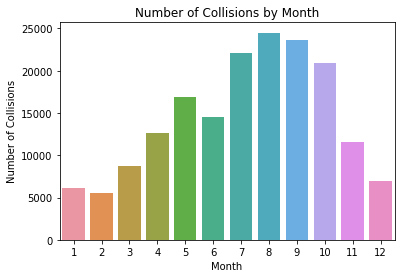

In [ ]:

# Kyle's work

#foo = df3.pivot('Aircraft','Airport ID','Incident Month')
#sns.heatmap(df3)
 
collisions = df3['Incident Month'].value_counts().sort_index()
ax = sns.barplot(x=collisions.index, y=collisions)
ax.set_title('Number of Collisions by Month')
ax.set_ylabel('Number of Collisions')
ax.set_xlabel('Month')
plt.show()

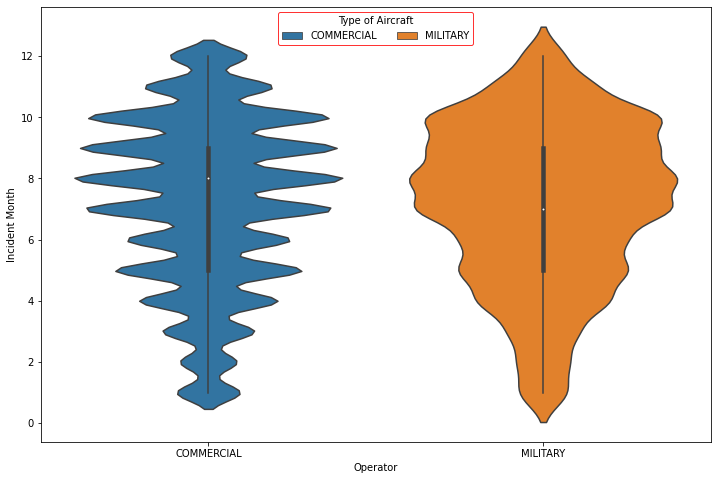

In [ ]:
# Brian
# Violin Plot
df5 = df2[['Record ID', 'Unique Operator Value', 'Operator', 'Incident Month', 'Unique Airport Value']].copy()
df5['Operator'].mask(df5['Operator'] != 'MILITARY', 'COMMERCIAL', inplace=True)
df5['Operator'] = df5['Operator'].replace(regex='MILITARY', value='MILITARY')
fig = plt.gcf()
ax = sns.violinplot(data=df5, x="Operator", y="Incident Month", hue="Operator", column="Incident Month",
               split=False, inner="box", dodge=False, scale="count")

ax.legend(title= 'Type of Aircraft', loc='upper center', edgecolor='red', ncol=2)
fig.set_size_inches(12, 8)
plt.show();

In [ ]:
# Brian
#
# Predict the month that a military or commercial aircraft hit a bird
# kNN Classification
#
predictors = ['Unique Operator Type Value', 'Unique Airport Value']
 #'Unique Operator Type Value', 'Unique Airport Value'
target = 'Incident Month'
X = df2[predictors].values
y = df2[target].values
# train your regression algorithm on the training data  (X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
# Print the first 5 rows of X_train.
print(X_train[:5])
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Print the first 5 rows of X_train again to make sure the data is scaled.
print("************ After scaling training data: ************")
print(X_train[:5])
# kNN Classification
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
# make predictions (using the trained algorithm) on X_train
predictions = knn.predict(X_test)
# compute the error on the training set:  (training RMSE)
rmse = np.sqrt(np.mean((y_test - predictions)**2))
print("RMSE train: ", rmse)
# Baseline Accuracy
baseline_accuracy = pd.Series(y_train).value_counts().iloc[0] / y_train.size
print('baseline accuracy: {0:.3f}'.format(baseline_accuracy))
accuracy = knn.score(X_test, y_test)
#accuracy = (predictions == y_test).mean()
print('accuracy: {0:.3f}'.format(accuracy))
# Make predictions and check mean squarded error on test set
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
# compute the error on the training set:  (training RMSE)
mse = ((predictions - y_test)**2).mean()
print(mse)
accuracy = (predictions == y_test).mean()
print('accuracy: {0:.3f}'.format(accuracy))
print(mse)
#print(.apply(zscore))
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
# make predictions
predicted = knn.predict(X_test)
rmse = np.sqrt(np.mean((y_test - predicted)**2))
print("RMSE: ", rmse)
# verify
predicted = knn.predict(X_test)
actual = y_test
np.mean(actual == predicted)

[[  0 236]
 [  0  31]
 [  0  57]
 [  0 180]
 [  0 208]]
************ After scaling training data: ************
[[-0.20138072  0.32663444]
 [-0.20138072 -0.51601321]
 [-0.20138072 -0.40914082]
 [-0.20138072  0.09644776]
 [-0.20138072  0.2115411 ]]
RMSE train:  3.9930211023267157
baseline accuracy: 0.140
accuracy: 0.106
9.031050776870096
accuracy: 0.019
9.031050776870096
RMSE:  3.0051706735009405


0.01862085535800096

In [ ]:
df2

,Record ID,Incident Year,Incident Month,Incident Day,Operator ID,Operator,Aircraft,Aircraft Type,Aircraft Make,Aircraft Model,Aircraft Mass,Engine Make,Engine Model,Engines,Engine Type,Engine1 Position,Engine2 Position,Engine3 Position,Engine4 Position,Airport ID,Airport,State,FAA Region,Warning Issued,Flight Phase,Visibility,Precipitation,Height,Speed,Distance,Species ID,Species Name,Species Quantity,Flight Impact,Aircraft Damage,Radome Strike,Radome Damage,Windshield Strike,Windshield Damage,Nose Strike,Nose Damage,Engine1 Strike,Engine1 Damage,Engine2 Strike,Engine2 Damage,Engine3 Strike,Engine3 Damage,Engine4 Strike,Engine4 Damage,Engine Ingested,Propeller Strike,Propeller Damage,Wing or Rotor Strike,Wing or Rotor Damage,Fuselage Strike,Fuselage Damage,Landing Gear Strike,Landing Gear Damage,Tail Strike,Tail Damage,Lights Strike,Lights Damage,Other Strike,Other Damage,Unique Operator Type Value,Unique Operator Value,Unique Aircraft Value,Unique Airport Value,Unique Aircraft Type Value,Unique Aircraft Make Value,Unique Engine Type Value,Unique State Value,Unique FAA Region Value,Unique Warning Issued Value,Unique Flight Phase Value,Unique Visibility Value,Unique Precipitation Value,Unique Species Name Value,Unique Flight Impact Value
39096,203146,2001,1,1,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KPHX,PHOENIX SKY HARBOR INTL ARPT,AZ,AWP,NaN,NaN,NaN,NaN,NaN,NaN,0.0,O2205,MOURNING DOVE,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39097,203841,2001,1,1,DAL,DELTA AIR LINES,MD-88,A,583,37,4.0,34.0,10,2.0,D,5,5.0,NaN,NaN,KLGA,LA GUARDIA ARPT,NY,AEA,N,TAKEOFF RUN,DAY,NONE,0.0,130.0,0.0,UNKBL,UNKNOWN LARGE BIRD,1,NONE,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
39098,213591,2001,1,1,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHNL,HONOLULU INTL ARPT,HI,AWP,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N5122,PACIFIC GOLDEN-PLOVER,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,2,0
39099,211928,2001,1,1,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHNL,HONOLULU INTL ARPT,HI,AWP,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N5122,PACIFIC GOLDEN-PLOVER,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,2,0
39100,205787,2001,1,1,UAL,UNITED AIRLINES,A-320,A,04A,3,4.0,23.0,1,2.0,D,1,1.0,NaN,NaN,KSMF,SACRAMENTO INTL,CA,AWP,NaN,APPROACH,NIGHT,NONE,NaN,NaN,NaN,J2104,NORTHERN PINTAIL,2-10,NONE,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,2,2,3,1,2,1,3,0,0,2,2,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163951,356969,2014,12,31,FDX,FEDEX EXPRESS,DC-10-10,A,583,24,4.0,22.0,7,3.0,D,1,6.0,1,NaN,KMEM,MEMPHIS INTL,TN,ASO,NaN,TAKEOFF RUN,DAY,NONE,0.0,144.0,0.0,UNKBS,UNKNOWN SMALL BIRD,1,NONE,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,39,65,1,1,1,20,4,0,1,1,1,5,1
163952,356973,2014,12,31,UAL,UNITED AIRLINES,B-737-800,A,148,43,4.0,10.0,1,2.0,D,1,1.0,NaN,NaN,KEWR,NEWARK LIBERTY INTL ARPT,NJ,AEA,Y,LANDING ROLL,DAY,NONE,0.0,NaN,0.0,K3302,RED-TAILED HAWK,1,NONE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,72,11,1,3,1,10,1,2,5,1,1,33,1
163953,356972,2014,12,31,SWA,SOUTHWEST AIRLINES,B-737-700,A,148,42,4.0,10.0,1,2.0,D,1,1.0,NaN,NaN,KONT,ONTARIO INTL ARPT,CA,AWP,Y,APPROACH,DAY,NONE,500.0,140.0,3.0,UNKBS,UNKNOWN SMALL BIRD,1,NONE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,8,52,19,1,3,1,3,0,2,2,1,1,5,1
163954,356967,2014,12,31,DAL,DELTA AIR LINES,B-737-800,A,148,43,4.0,10.0,1,2.0,D,1,1.0,NaN,NaN,KSLC,SALT LAKE CITY INTL,UT,ANM,Y,APPROACH,DAY,NONE,NaN,NaN,NaN,NE104,RING-BILLED GULL,1,NONE,0,0,

In [ ]:
# Nick
#
# Predict the month that a military or commercial aircraft hit a bird
# kNN Classification
predictors = ['Unique Operator Type Value', 'Unique Airport Value']
 #'Unique Operator Type Value', 'Unique Airport Value'
target = 'Incident Month'
X = df2[predictors].values
y = df2[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=0)
print("************ Before scaling training data: ************")
print(X_train[:5])
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Print the first 5 rows of X_train again to make sure the data is scaled.
print("************ After scaling training data: ************")
print(X_train[:5])
# kNN Classification
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
predicted = knn.predict(X_test)
# Baseline Accuracy
baseline_accuracy = pd.Series(y_train).value_counts().iloc[0] / y_train.size
print('baseline accuracy: {0:.3f}'.format(baseline_accuracy))

#kNN Clasification Accuracy
accuracy = knn.score(X_test, y_test)
print('classification accuracy: {0:.3f}'.format(accuracy))

# Make predictions and check mean squarded error on test set
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
mse = ((predicted - y_test)**2).mean()
accuracy = (predicted == y_test).mean()
print('regression accuracy: {0:.3f}'.format(accuracy))
print("MSE: ", mse)

************ Before scaling training data: ************
[[  0 111]
 [  0 172]
 [  0 255]
 [  0  24]
 [  0 182]]
************ After scaling training data: ************
[[-0.20200719 -0.1868145 ]
 [-0.20200719  0.064493  ]
 [-0.20200719  0.40643599]
 [-0.20200719 -0.54523667]
 [-0.20200719  0.10569095]]
baseline accuracy: 0.140
classification accuracy: 0.151
regression accuracy: 0.151
MSE:  12.047573282075925


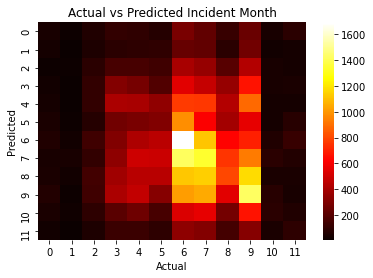

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
confusion_matrix
sns.heatmap(confusion_matrix,cbar=True,cmap='hot')
plt.title('Actual vs Predicted Incident Month')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show();

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

Christal & Kyle's linear regression...

In [ ]:
# Christal & Kyle

predictors = ['Distance', 'Speed']
target = 'Height'

# Copy df to df0 and drop rows with na values in any predictor/target columns
df0 = df.copy()

for predictor in predictors:
  df0 = df0[df[predictor].notna()]
df0 = df0[df[target].notna()]

#print(df0[['Distance','Speed','Height']].isna().sum())

X = df0[predictors].values
y = df0[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

reg = LinearRegression()
reg.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print('Distance coef: {:.2f}'.format(reg.coef_[0]))
print('Speed coef: {:.2f}'.format(reg.coef_[1]))

Distance coef: 203.71
Speed coef: 9.92


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

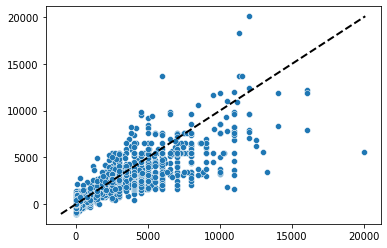

In [ ]:
predicted = reg.predict(X_test)
sns.scatterplot(y_test, predicted)
plt.plot((np.min([y_test, predicted]) , np.max([y_test, predicted])), (np.min([y_test, predicted]) , np.max([y_test, predicted])),
color='black', linewidth=2, linestyle='dashed')
plt.savefig("abc.png")
files.download("abc.png") 

In [ ]:
df['Height'].max()



31300.0

In [ ]:
#Christal
r2 = reg.score(X, y)
print('r-squared value: {:.2f}'.format(r2))

rmse = np.sqrt(((reg.predict(X) - y)**2).mean())
print("RMSE: {:.2f}".format(rmse))

r-squared value: 0.77
RMSE: 773.90


Kyle's 'Height' vs 'Unique Operator Type Value' experiment

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

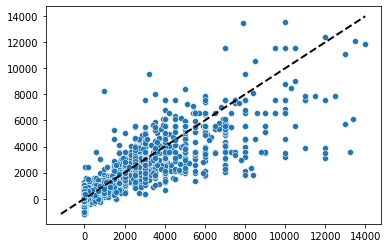

In [ ]:
# Kyle
df2[['Unique Operator Type Value','Distance','Speed','Height']]
predictors0_2 = ['Distance', 'Speed', 'Unique Operator Type Value']
target0_2 = 'Height'

# Copy df2 to df0_2 and drop rows with na values in any predictor/target columns
df0_2 = df2.copy()
for predictor in predictors0_2:
  df0_2 = df0_2[df0_2[predictor].notna()]
df0_2 = df0_2[df0_2[target0_2].notna()]

X = df0_2[predictors0_2].values
y = df0_2[target0_2].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

reg = LinearRegression()
reg.fit(X_train,y_train)

predicted = reg.predict(X_test)
sns.scatterplot(y_test, predicted)
plt.plot((np.min([y_test, predicted]) , np.max([y_test, predicted])), (np.min([y_test, predicted]) , np.max([y_test, predicted])),
color='black', linewidth=2, linestyle='dashed')
plt.savefig("abc.png")
files.download("abc.png") 
# sns.pairplot(df0_2[['Unique Operator Type Value','Distance','Speed','Height']])

In [ ]:
r2 = reg.score(X_test, y_test)
print('r-squared value: {:.2f}'.format(r2))

rmse = np.sqrt(((reg.predict(X_test) - y_test)**2).mean())
print("RMSE: {:.2f}".format(rmse))

r-squared value: 0.78
RMSE: 776.98


In [ ]:
print('Intersection: {:.2f}'.format(reg.intercept_))
print('Distance: {:.2f}'.format(reg.coef_[0]))
print('Speed coef: {:.2f}'.format(reg.coef_[1]))
print('Unique Operator coef: {:.2f}'.format(reg.coef_[2]))

Intersection: -1170.24
Distance: 198.61
Speed coef: 11.10
Unique Operator coef: -27.81


In [ ]:
# UNUSED

# Kyle

# predictors0_2 = ['Distance', 'Speed', 'Height']
# target0_2 = 'Unique Operator Type Value'

# Copy df2 to df0_2 and drop rows with na values in any predictor/target columns
# df0_2 = df2.copy()
# for predictor in predictors0_2:
#   df0_2 = df0_2[df0_2[predictor].notna()]
# df0_2 = df0_2[df0_2[target0_2].notna()]

# #print(df0[['Distance','Speed','Height']].isna().sum())

# X0_2 = df0_2[predictors0_2].values
# y0_2 = df0_2[target0_2].values

# X_train0_2, X_test0_2, y_train0_2, y_test0_2 = train_test_split(X0_2, y0_2, test_size=0.25, random_state=0)

# reg0_2 = LinearRegression()
# reg0_2.fit(X_train0_2,y_train0_2)

# print('Distance coef: {:.2f}'.format(reg0_2.coef_[0]))
# print('Speed coef: {:.2f}'.format(reg0_2.coef_[1]))
# print('Height coef: {:.2f}'.format(reg0_2.coef_[2]))

# predicted0_2 = reg0_2.predict(X_test0_2)
# sns.scatterplot(y_test0_2, predicted0_2)
# plt.plot((np.min([y_test0_2, predicted0_2]) , np.max([y_test0_2, predicted0_2])), (np.min([y_test0_2, predicted0_2]) , np.max([y_test0_2, predicted0_2])),
# color='black', linewidth=2, linestyle='dashed')

# r2_0_2 = reg0_2.score(X0_2, y0_2)
# print('r-squared value: {:.2f}'.format(r2_0_2))
# rmse0_2 = np.sqrt(((reg0_2.predict(X0_2) - y0_2)**2).mean())
# print("RMSE: {:.2f}".format(rmse0_2))